## Natural Language Processing 

You will be dealing with movie review data that includes both positive and negative reviews in this assignment. You will use Sentiment Analysis to assess if a given review is positive or negative using the provided dataset.

Therefore, we will make use of Naive Bayes algorithm to perform sentiment analysis on the movie review dataset.

## Importing the Libraries

In [150]:
import numpy as np
import math
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import string
warnings.filterwarnings("ignore")
nltk.download('punkt')
nltk.download('wordnet')
nltk.download("stopwords")
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Reading the data

When reading the data, ensure that the '.csv' file is in the same location where your jupyter notebook is used. This way the files are organized and easy to read using the pandas library.

In [151]:
## Reading the data and removing columns that are not important.
df = pd.read_csv("movie_reviews.csv", sep = ',', encoding = 'latin-1', usecols = lambda col: col not in ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])

In [152]:
# print head of data frame with help of head function
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,"Petter Mattei's ""Love in the Time of Money"" is...",positive
4,"Probably my all-time favorite movie, a story o...",positive


## Count plot of the output categories: positive or negative

Feel free to take a look at the output and whether the classes are balanced or imbalanced.

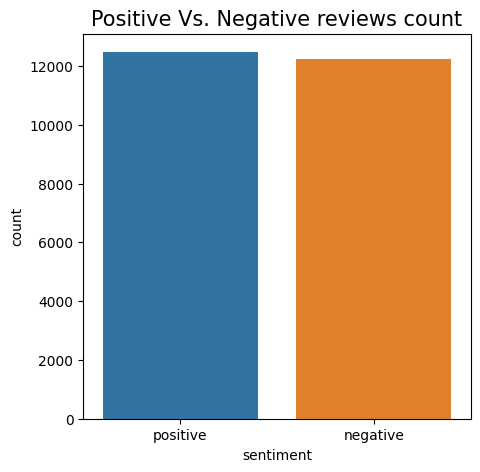

In [153]:
plt.figure(figsize = (5,5))
sns.countplot(data=df, x = "sentiment")
plt.title("Positive Vs. Negative reviews count", fontsize = 15)
plt.show()

## Upsampling the minority class: (5 points)

It is known that Naive bayes is not robust to class imbalance. It could be seen above that the data is little imbalanced. Therefore, class balancing can be done before giving it to the Naive Bayes model for prediction.

Feel free to use 'resample' library from sklearn.

In [154]:
## hint: use resample from sklearn.utils
from sklearn.utils import resample

df_majority = df[df['sentiment'] == 'positive']
df_minority = df[df['sentiment'] == 'negative']

negative_upsample = resample(df_minority, replace = True,
                        n_samples = df_majority.shape[0],
                        random_state = 101)

df_upsampled = pd.concat([df_majority, negative_upsample])  # concat two data frames i,e majority class data set and upsampled minority class data set
df_upsampled = df_upsampled.sample(frac = 1)

In [155]:
## Just to ensure that upsampling was done successfully, take a look at the shape of the data in
## this cell.

# print the shape of data set with the help of shape function having "negative" as class label
df_upsampled[df_upsampled.sentiment=='negative'].shape

(12474, 2)

### Expected Output :
(12474, 2)

In [156]:
## Ensure that the same number of data points are present for both 'positive' and 'negative' data

# print the shape of data set with the help of shape function having "positive" as class label
df_upsampled[df_upsampled.sentiment=='positive'].shape

(12474, 2)

### Expected Output :
(12474, 2)

In [157]:
## In this cell, we are going to be dividing the data into train and test points
## Ensure that you store the upsampled data in a variable called 'df_upsampled'
## so that the below operations are performed successfully


## Considering 10000 positive and 10000 negative data points
negative_data_points_train = df_upsampled[df_upsampled["sentiment"] == "negative"].iloc[:10000]
positive_data_points_train = df_upsampled[df_upsampled["sentiment"] == "positive"].iloc[:10000]

## Considering the remaining data points for test
negative_data_points_test = df_upsampled[df_upsampled["sentiment"] == "negative"].iloc[10000:]
positive_data_points_test = df_upsampled[df_upsampled["sentiment"] == "positive"].iloc[10000:]

## Concatenate the training positive and negative reviews
X_train = pd.concat([positive_data_points_train["review"], negative_data_points_train["review"]])
## Concatenating the training positive and negative outputs
y_train = pd.concat([positive_data_points_train["sentiment"], negative_data_points_train["sentiment"]])

## Concatenating the test positive and negative reviews
X_test = pd.concat([positive_data_points_test["review"], negative_data_points_test["review"]])
## Concatenating the test positive and negative outputs
y_test = pd.concat([positive_data_points_test["sentiment"], negative_data_points_test["sentiment"]])


In [158]:
## Take a look at the total number of classes and their count using '.value_counts()' for y_train and y_test.
## Ensure that there are equal number of positive and negative reviews.
y_train.value_counts()

positive    10000
negative    10000
Name: sentiment, dtype: int64

### Expected Output:
negative    10000<br>
positive    10000<br>
Name: sentiment, dtype: int64

In [159]:
y_test.value_counts()

positive    2474
negative    2474
Name: sentiment, dtype: int64

### Expected Output :
negative    2474<br>
positive    2474<br>
Name: sentiment, dtype: int64

## Q1. Pre-process the reviews: (10 points)

We know that a review contains links, punctuation, stopwords and many other words that don't give a lot of meaning for the Naive Bayes model for prediction.

In the cell below, one must implement text-preprocessing and remove links, punctuations and stopwords. It is also important to lowercase the letters so that 'Admire' and 'admire' are not treated as different words.

In addition to this, perform stemming operation so that similar words are reduced. To know more about stemming, feel free to take a look at this link.

https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html

In [160]:
# TASK CELL

def clean_review(review):
    '''
    Input:
        review: a string containing a review.
    Output:
        review_cleaned: a processed review.

    '''
    #Converting the text to lower case
    review = review.lower()
    #Removing URL's that begin with a http and www
    review = re.sub(r'https?://\S+', '', review)
    review = re.sub(r'[^\w\s]', '', review)
    #Removing punctuations
    review = "".join([char for char in review if char not in string.punctuation])
    #Removing stopwords
    predefined_stopword_list = nltk.corpus.stopwords.words('english')
    review = " ".join([word for word in re.split('\W+', review) if word not in predefined_stopword_list])
    #Tokenizing using the word tokenizer function
    review = word_tokenize(review)
    # Lemmatizing input
    lemmatizer = WordNetLemmatizer()
    review_cleaned =" ".join([lemmatizer.lemmatize(w) for w in review])

    return review_cleaned

## Q2. Implement a find_occurrence function (5 points):

In this function, we find the total occurrence of a word giving information such as label, word and frequency dictionary.

Note that this function is used later in the code when we are going to be predicting the output using Naive Bayes.

In [161]:
# TASK CELL
def find_occurrence(frequency, word, label):

    '''
    Params:
        frequency: a dictionary with the frequency of each pair (or tuple)
        word: the word to look up
        label: the label corresponding to the word
    Return:
        n: the number of times the word with its corresponding label appears.
    '''
    n = 0
    if (word, label) in frequency:
        n = frequency[(word, label)]

    return n


### Converting output to numerical format:

We have outputs as 'positive' or 'negative'. In the cell below, we convert it to a numerical format.

In [162]:
## With the use of mapping function, we replace
## the label in the form of string to an integer.

output_map = {'positive': 0, 'negative': 1}
y_train = y_train.map(output_map)
y_test = y_test.map(output_map)

In [163]:
## Ensuring that there are equal number of classes on the training data.
y_train.value_counts()

0    10000
1    10000
Name: sentiment, dtype: int64

In [164]:
## Choosing a random review and taking a look at it.
X_train.iloc[0]

'This is a romantic comedy where Albert Einstein, played wonderfully by Walter Matthau, and his cronies play match maker to his niece (Meg Ryan) and a talented auto mechanic (Tim Robbins). The interplay among these major roles is augmented by a terrific supporting cast of well recognized character actors. This movie is cute and fun ... a "feel-gooder"! Hearty recommendations.'

From the above cell output, it could be seen that there are a lot of words that don't add a lot of meaning to the text.

Therefore, those words would be removed. It also reduces the computation time.

Therefore, it is a good practice we are following.

In [165]:
custom_review = X_train.iloc[0]

# print cleaned review
print(clean_review(custom_review))

romantic comedy albert einstein played wonderfully walter matthau crony play match maker niece meg ryan talented auto mechanic tim robbins interplay among major role augmented terrific supporting cast well recognized character actor movie cute fun feelgooder hearty recommendation


We now use this function to pre-process the review and remove words that don't add a lot of meaning in our model.

## Q3. Implementing review counter function: (5 points)

It is now time to implement the count function for the reviews.

In this function, we count the occurrence of words and get the probabilities
for the words based on the training data.

In other words, we get the probability of occurrence of a word, given that the output is 'positive'.

Similarly, we also compute the probability of occurence of a word, given that the output is 'negative'.



In [166]:
# TASK CELL
def review_counter(output_occurrence, reviews, positive_or_negative):
    '''
    Params:
        output_occurrence: a dictionary that will be used to map each pair to its frequency
        reviews: a list of reviews
        positive_or_negative: a list corresponding to the sentiment of each review (either 0 or 1)
    Return:
        output: a dictionary mapping each pair to its frequency
    '''
    ## Steps :
    # define the key, which is the word and label tuple
    for label, review in zip(positive_or_negative, reviews):
      split_review = clean_review(review).split()
      for word in split_review:
        key = (word, label)
        # if the key exists in the dictionary, increment the count
        if key in output_occurrence:
            output_occurrence[key] += 1
        # else, if the key is new, add it to the dictionary and set the count to 1
        else:
            output_occurrence[key] = 1

    return output_occurrence


### Test your function with example reviews:

Feel free to run the cell below and understand whether the above function that you have defined is producing the optimum results.

In [167]:
# Testing your function

result = {}
reviews = ['got bored throught the moview', 'The movie was fantastic', 'Will not watch it again', 'Was bored, it was a complete waste of time and money', 'Enjoyed the movie to the fullest']
ys = [1, 0, 1, 1, 0]
review_counter(result,reviews, ys)

{('got', 1): 1,
 ('bored', 1): 2,
 ('throught', 1): 1,
 ('moview', 1): 1,
 ('movie', 0): 2,
 ('fantastic', 0): 1,
 ('watch', 1): 1,
 ('complete', 1): 1,
 ('waste', 1): 1,
 ('time', 1): 1,
 ('money', 1): 1,
 ('enjoyed', 0): 1,
 ('fullest', 0): 1}

### Expected Output:
 {('bored', 1): 2, <br>
 ('complete', 1): 1, <br>
 ('enjoyed', 0): 1, <br>
 ('fantastic', 0): 1, <br>
 ('fullest', 0): 1, <br>
 ('got', 1): 1, <br>
 ('money', 1): 1, <br>
 ('movie', 0): 2, <br>
 ('moview', 1): 1, <br>
 ('throught', 1): 1, <br>
 ('time', 1): 1, <br>
 ('waste', 1): 1, <br>
 ('watch', 1): 1}

In [168]:
# Build the freqs dictionary for later uses

freqs = review_counter({}, X_train, y_train)

In [169]:
## Run this cell to get an idea about the corpus of words and their occurrence along with labels.
## In this, we are computing the frequency of occurrence of word given that a review is 'positive'.
## Similarly, we also compute the frequence of occurence of word given that a review is 'negative'.
freqs

{('romantic', 0): 399,
 ('comedy', 0): 1528,
 ('albert', 0): 121,
 ('einstein', 0): 26,
 ('played', 0): 1221,
 ('wonderfully', 0): 214,
 ('walter', 0): 119,
 ('matthau', 0): 87,
 ('crony', 0): 8,
 ('play', 0): 2051,
 ('match', 0): 270,
 ('maker', 0): 149,
 ('niece', 0): 23,
 ('meg', 0): 52,
 ('ryan', 0): 155,
 ('talented', 0): 228,
 ('auto', 0): 21,
 ('mechanic', 0): 23,
 ('tim', 0): 164,
 ('robbins', 0): 23,
 ('interplay', 0): 21,
 ('among', 0): 404,
 ('major', 0): 374,
 ('role', 0): 1923,
 ('augmented', 0): 5,
 ('terrific', 0): 282,
 ('supporting', 0): 428,
 ('cast', 0): 1609,
 ('well', 0): 4588,
 ('recognized', 0): 57,
 ('character', 0): 5504,
 ('actor', 0): 2460,
 ('movie', 0): 17335,
 ('cute', 0): 222,
 ('fun', 0): 1182,
 ('feelgooder', 0): 1,
 ('hearty', 0): 11,
 ('recommendation', 0): 35,
 ('paul', 0): 342,
 ('kersey', 0): 14,
 ('death', 0): 892,
 ('wish', 0): 443,
 ('3', 0): 385,
 ('far', 0): 993,
 ('removed', 0): 29,
 ('original', 0): 1076,
 ('film', 0): 19418,
 ('remember', 0

## Q4. Training the Naive Bayes Model: (20 points)

Now we are in the training phase of the Naive Bayes algorithm. In this cell, take a look at the ways to calculate the log likelihood and log prior values as these are important for testing in the next few cells.

Also calculate the frequency of occurrence of words where the output is negative. In the same way, calculate the word frequency count using the above functions in order to compute the log likelihood.

Return the logprior and loglikelihood output by the model from this function.

In [170]:
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of reviews
        train_y: a list of labels correponding to the reviews (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0


    # calculate V, the number of unique words in the vocabulary
    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)

    # calculate num_pos and num_neg - the total number of positive and negative words for all documents
    num_pos = num_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] == 0:

            # Increment the number of positive words by the count for this (word, label) pair
            num_pos = num_pos + freqs[pair]

        # else, the label is negative
        else:

            # increment the number of negative words by the count for this (word,label) pair
            num_neg = num_neg + freqs[pair]

    # Calculate num_doc, the number of documents
    num_doc = len(train_y)

    # Calculate D_pos, the number of positive documents
    pos_num_docs = train_y.value_counts()[0]

    # Calculate D_neg, the number of negative documents
    neg_num_docs = train_y.value_counts()[1]

    # Calculate logprior
    logprior = np.log(pos_num_docs) - np.log(neg_num_docs)

    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = freqs.get((word, 0), 0)
        freq_neg = freqs.get((word, 1), 0)

        # calculate the probability that each word is positive, and negative
        p_w_pos = (1 + freq_pos) / ((1*V) + num_pos)
        p_w_neg = (1 + freq_neg) / ((1*V) + num_neg)

        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos/p_w_neg)


    return logprior, loglikelihood

In [171]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything
logprior, loglikelihood = train_naive_bayes(freqs, X_train, y_train)
print(logprior)
print(len(loglikelihood))

0.0
91699


### Expected Output

0.0 <br>
91425

## Q5. Implementing Naive Bayes Predict Function: (10 points)

It is now time to make our prediction as to whether a given review is negative or positive respectively.

After adding the log likelihood values, ensure that the output is 1 (negative) if the sum of the log likelihood value is greater than 0 and 0 (positive) if the sum of the log likelihood is less than or equal to 0.

In [192]:
# TASK 4 CELL

def naive_bayes_predict(review, logprior, loglikelihood):
    '''
    Params:
        review: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Return:
        total_prob: the sum of all the loglikelihoods of each word in the review (if found in the dictionary) + logprior (a number)

    '''

    # process the review to get a list of words
    word_l = clean_review(review).split()

    # initialize probability to zero
    total_prob = 0

    # add the logprior
    total_prob = total_prob + logprior

    for word in word_l:

        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # add the log likelihood of that word to the probability
            total_prob = total_prob + loglikelihood[word]


    return 1 if total_prob < 0 else 0

In [193]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Experiment with your own review.
my_review = "I thought this series was going to be another fun, action series with some dynamic plots and great performances. I was wrong. While I like Jamie Denton, this show is hardly worth watching at all, unless you enjoy watching some people brutalized and the actions of the agents supposedly warranted under the theme of national security. The show is great propaganda for the current government, and spews out jingoism as though we talk that way every day. After a couple of episodes, it was boring the hell out of me, and I started watching reruns of House Invaders on BBCAmerica instead. Rather watch CSI and Without a Trace, without a doubt."
p = naive_bayes_predict(my_review, logprior, loglikelihood)
print('The expected output is', p)

The expected output is 1


### Expected Output :
The expected output is 1

**My own review for validating the prediction**

In [194]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Experiment with your own review.
my_review = "It was beautiful."
p = naive_bayes_predict(my_review, logprior, loglikelihood)
print('The expected output is', p)

The expected output is 0


## Q6. Implementing Naive Bayes Test function: (10 points)

In this function, implement the previous functions such as naive_bayes_predict to get the predictions for the test set.

In addition to this, the function should return the total number of reviews that it correctly classified as 'positive' or 'negative'.

In [174]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Input:
        test_x: A list of reviews
        test_y: the corresponding labels for the list of reviews
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of reviews classified correctly)/(total # of reviews)
    """
    accuracy = 0


    y_hats = []
    for review in test_x:
        # if the prediction is > 0
        if naive_bayes_predict(review, logprior, loglikelihood) > 0:
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0

        # append the predicted class to the list y_hats
        y_hats.append(y_hat_i)

    # error is the average of the absolute values of the differences between y_hats and test_y
    error = np.mean(np.absolute(y_hats-test_y))

    accuracy = 1 - error


    return accuracy

In [175]:
# For grading purpose only
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Run this cell to test your function

for review in ["If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!!",
                "What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative direction, too. Some VERY faint echoes of Fargo here, but it just doesn't come off.",
                "I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the romance between Joe and Jean keeps me on the edge of my seat, plus I still think Bryan Brown is the tops. Brilliant Film.",
                "Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement value. About as unentertaining, uninstructive and just plain dull as a film can be."]:
    p = naive_bayes_predict(review, logprior, loglikelihood)
    print(f'{review[:100]} -> {p:.2f}')


If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00


### Expected Output :

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00 <br>
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00<br>
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00 <br>
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00



In [176]:
# Feel free to check the sentiment of your own review below
my_review ='The moview was very boring, I wanted to leave in the middle'
naive_bayes_predict(my_review, logprior, loglikelihood)

1

### Expected Output :
1

# Q7. Evaluate the accuracy (10 Points)
1. Split your data into training and test sets using random selection. Set the seed as parameter of the function so that user can select a different training and test set by changin seed.

2. Calculate model paramters with training set.

3. Print confusion matrix for training and test set.

4. Examine False Positive and False Negative cases and provide reasoning why they get misclassified.

**Solution 7.1:**
Split your data into training and test sets using random selection. Set the seed as parameter of the function so that user can select a different training and test set by changin seed.



In [177]:
import random
from sklearn.model_selection import train_test_split
def data_split(data, seed):
    '''
    Split the data into training and test sets using random selection, with the positive and negative sentiment balanced.

    Input:
        data: a DataFrame of reviews
        seed: the seed for the random number generator
    Output:
        train_x: a list of reviews for the training set
        train_y: a list of labels correponding to the reviews for the training set
        test_x: a list of reviews for the test set
        test_y: a list of labels correponding to the reviews for the test set
    '''

    # Shuffling the data
    random.seed(seed)
    df_majority = df[df['sentiment'] == 'positive']
    df_minority = df[df['sentiment'] == 'negative']

    negative_upsample = resample(df_minority, replace = True,
                        n_samples = df_majority.shape[0],
                        random_state = seed)

    df_upsampled = pd.concat([df_majority, negative_upsample])  # concat two data frames i.e majority class data set and upsampled minority class data set
    df_upsampled = df_upsampled.sample(frac = 1)

    ## Considering 10000 positive and 10000 negative data points
    negative_data_points_train = df_upsampled[df_upsampled['sentiment'] == 'negative'].iloc[:10000]
    positive_data_points_train = df_upsampled[df_upsampled['sentiment'] == 'positive'].iloc[:10000]

    ## Considering the remaining data points for test
    negative_data_points_test = df_upsampled[df_upsampled['sentiment'] == 'negative'].iloc[10000:]
    positive_data_points_test = df_upsampled[df_upsampled['sentiment'] == 'positive'].iloc[10000:]

    ## Concatenate the training positive and negative reviews
    X_train = pd.concat([positive_data_points_train['review'], negative_data_points_train['review']])
    ## Concatenating the training positive and negative outputs
    y_train = pd.concat([positive_data_points_train['sentiment'], negative_data_points_train['sentiment']])

    ## Concatenating the test positive and negative reviews
    X_test = pd.concat([positive_data_points_test['review'], negative_data_points_test['review']])
    ## Concatenating the test positive and negative outputs
    y_test = pd.concat([positive_data_points_test['sentiment'], negative_data_points_test['sentiment']])

    return X_train, y_train, X_test, y_test

# Data split
train_x, train_y, test_x, test_y = data_split(df, 101)

# converting y variable to 0 and 1
output_map = {'positive': 0, 'negative': 1}
y_train = train_y.map(output_map)
y_test = test_y.map(output_map)

**Solution 7.2:** Calculate model paramters with training set.



In [178]:
# Model paramters with training set.
freqs_n = review_counter({}, train_x, y_train)
logprior, loglikelihood = train_naive_bayes(freqs, train_x, y_train)
print(logprior)
print(len(loglikelihood))

# getting logprior and loglikihood and storing it in Naive
Naive = train_naive_bayes(freqs_n, X_train, y_train)

0.0
91699


**Solution 7.3:** Print confusion matrix for training and test set.

In [179]:
# predictions
y_hat = []
for i in X_train:
    y_hat.append(naive_bayes_predict(i,Naive[0],Naive[1]))

In [180]:
# confusion matrix for the traning set
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_train, y_hat)
cnf_matrix

array([[9107,  893],
       [ 450, 9550]])

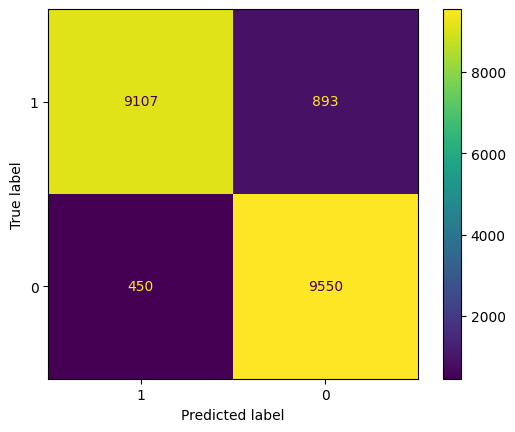

In [181]:
#Display of confusion matrix for train data
from sklearn import metrics
cnf_matrix_display = metrics.ConfusionMatrixDisplay(cnf_matrix, display_labels = [1, 0])
cnf_matrix_display.plot()
plt.show()

In [182]:
# training set accuracy
test_naive_bayes(X_train, y_train, Naive[0], Naive[1])

0.93285

In [183]:
y_hat_t = []
for i in X_test:
    y_hat_t.append(naive_bayes_predict(i,Naive[0],Naive[1]))

In [184]:
# confusion matrix for test set
cnf_matrix = confusion_matrix(y_test, y_hat_t)
cnf_matrix

array([[2233,  241],
       [ 116, 2358]])

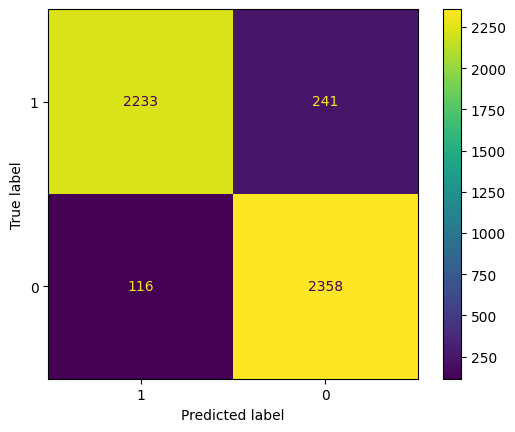

In [185]:
#Display of confusion matrix for test data
cnf_matrix_display = metrics.ConfusionMatrixDisplay(cnf_matrix, display_labels = [1, 0])
cnf_matrix_display.plot()
plt.show()

In [186]:
# test set accuracy
test_naive_bayes(X_test, y_test, Naive[0], Naive[1])

0.9278496362166532

**Solution 7.4:**Examine False Positive and False Negative cases and provide reasoning why they get misclassified.

In [187]:
test_predicted_labels = [naive_bayes_predict(review, logprior, loglikelihood) for review in test_x]

In [188]:
#Finding the False Positives and false negatives
false_positive_indices = []
false_negative_indices = []
for i in range(len(y_test)):
    if y_test.iloc[i] == 1 and test_predicted_labels[i] == 0:
        false_positive_indices.append(i)
    elif y_test.iloc[i] == 0 and test_predicted_labels[i] == 1:
        false_negative_indices.append(i)




In [189]:
# Retreive the corresponding misclassified reviews
false_positive_reviews = [test_x.iloc[i] for i in false_positive_indices]
false_negative_reviews = [test_x.iloc[i] for i in false_negative_indices]

In [190]:
# Printing the Misclassified reviews
print("False Positive Cases:")
for i, review in enumerate(false_positive_reviews):
    print(f"Review: {review}")
    print(f"Predicted Label: {test_predicted_labels[false_positive_indices[i]]}")
    print(f"Actual Label: {y_test.iloc[false_positive_indices[i]]}")
    print()

False Positive Cases:
Review: Stan Laurel and Oliver Hardy are the most famous comedy duo in history, and deservedly so, so I am happy to see any of their films. Ollie is recovering from a broken leg in hospital, and with nothing else to do, Stan decides to visit him, and take him some boiled eggs and nuts, instead of candy. Chaos begins with Stan curiously pulling Ollie's leg cast string, and manages to push The Doctor (Billy Gilbert) out the window, clinging on to it, getting Ollie strung up to the ceiling. When the situation calms down, Stan gets Ollie's clothes, as the Doctor wants them both to leave, and he also manages to sit on a syringe, accidentally left by the nurse, filled with a sleeping drug, which comes into effect while he is driving (which you can tell is done with a car in front of a large screen. Filled with some likable slapstick and not too bad (although repetitive and a little predictable) classic comedy, it isn't great, but it's a black and white film worth lookin

In [191]:
#Finding the False Negatives:
print("False Negative Cases:")
for i, review in enumerate(false_negative_reviews):
    print(f"Review: {review}")
    print(f"Predicted Label: {test_predicted_labels[false_negative_indices[i]]}")
    print(f"Actual Label: {y_test.iloc[false_negative_indices[i]]}")
    print()

False Negative Cases:
Review: I remember seeing this film in the theater and liking it. I happened to stumble upon it on fear net last month and watched it again and found it better with age. First of all for those of you who describe this as 80s cheese if you objectively compare it with the horror flicks of the past 2 decades it compares quite well if stacked up against films in its unique horror sub genre which I would term action/horror as opposed to psychological horror such as "The Shining" or "the exorcist".<br /><br />Furthermore for its budget this film really delivers the goods (or in this instance bad). The film actually has some character development and gives enough of a history of the infamous hull house to get the atmosphere right before the characters set foot in the front door. The film also has several hilarious one liners and gives the appropriate mood that a creepy horror flick should have. If you compare NOD to contemporary big budget horror films such as "I am lege

**Analysis of False Positive Case:**<br>
**Review**: What has Rajiv Rai done to himself? Once a hit director of films like Tridev and Vishwatama is now making one bad film after another. I was initially excited at the thought of Rajiv Rai returning to the action genre but that soon fizzled out. As a Rajiv Rai fan I thought I should at least give it a go but I left after an hour. One reason for me leaving the film so early so the amount of Paki- bashing in the film, this was not in Rai's previous venture.<br />A lot of directors have tried Paki- bashing but I did not expect it from Rajiv Rai Another letdown was the music. Rajiv Rai's have always had good music until now. There is only one good song and that is Tere dekh dekh Ladgayan. The performances are not upto scratch, not even from Rai Loyalist Naseer-Uddin- Shah. Avoidable fare from once my favourite director.<br>
**Predicted Label: 0**<br>
**Actual Label: 1**<br>
**REASON:**<br>
The given review is considered as false positive as the machine learning model failed on considering few cases like it did not understand the sarcasm and indirect criticism(“What has Rajiv Rai done to himself?”). The model couldn't determine the negative sentiment. The word “excited” is generally positive, but in this review, it’s used to express disappointment The statement like(“I was initially excited…but that soon fizzled out”). But, the model misunderstood the sentiment.

**Analysis of False Negative Case:**<br>
**Review**:This is simply the funniest movie I've seen in a long time. The bad acting, bad script, bad scenery, bad costumes, bad camera work and bad special effects are so stupid that you find yourself reeling with laughter.So it's not gonna win an Oscar but if you've got beer and friends round then you can't go wrong.<br>
**Predicted Label: 1**<br>
**Actual Label: 0**<br>
**REASON:**<br>
The usage of word 'bad' by which is considered as a negative expression was used multiple times in the review but the intension of the reviewer was not to criticize. This sentiment analysis was complex for the model to determine. Towards the end of the review, it gives out the meaning that it is fun to watch the movie with friends and the phrase "can't go wrong" was not understood by the model.

**In Summary reason for misclassification:**<br>
The model we develop has limitations while performing sentiment analysis. There are certain words and phrases which are used for sarcasm or indirect representation(linguistic nuances) which is difficult for the model to determine. In these situations false positives and false negatives arise.

# Q8. Modularize your calssifier (10 points)
1. Convert your code into a python module text_classifier.py

2. The user should be able to launch the application on command prompt using python test_classifier.py command. The module will automatically load the model paramters from a local file of your choice and be ready to take the input from user on command prompt. The program will preprocess user input, tokenize and predict the class.

3. Your module will take the input from user and output sentiment class in an indefinite loop. The output should printout the probabilities for each input token along with the final classification decision. Program will quit if user enters X.


Completed and file subitted separately

# Q9. Theory Questions: (10 points)

1. Why is Laplace Smoothing or Additive Smoothing required while executing Naive Bayes operations, especially for text classification? Show how not having additive smoothing leads to bad outcomes by using an example of training and the test set. (10 points)


2. Why are logarithmic values computed instead of only probability values in the Naive Bayes algorithm? (5 points)

**Solution 1.**Laplace smoothing, also known as additive smoothing, is required in Naive Bayes because it helps to prevent overfitting of the model to the training data and reduces the impact of zero probabilities.

In Naive Bayes, the probabilities of each class and each feature (word in text classification) are estimated from the training data. However, it's possible that a feature may not appear in some instances of a particular class, leading to a zero probability estimate. When this happens, the product of all these probabilities becomes zero, even if some of the other probabilities are non-zero. This makes it impossible to estimate the class probabilities accurately.

Laplace smoothing addresses this issue by adding a small positive value, typically 1, to the count of each feature in each class. This effectively gives a minimum non-zero probability estimate for each feature in each class, even if it doesn't appear in some instances.

Here's an example to show the difference in results between using Laplace smoothing and not using it:

Lets say the only words in the vocabulary are worst, great, bad, good with probabilities as follows-

Class probabilities:

P(positive) = 3/5 = 0.6, P(negative) = 2/5 = 0.4

Conditional probabilities:

P(good|positive) = 3/3 = 1, P(good negative) = 2/2 = 1
P(bad|positive) = 2/3 = 0.67, P(bad|negative) = 3 2 = 1.5
P(great|positive) = 4/3 = 1.33, P(great|negative) = 0/2 = 0
P(worst|positive) = 1/3 = 0.33, P(worst|negative) = 4/2 = 2

Now, let's say we have a test set with the following movie review: "the movie was great"

P(positive|"the movie was great") = P(positive)* P(great|positive)* P("the"|positive)* P("movie"|positive)*
P("was"|positive) = 0.6 * 1.33 * 0 * 0 * 0 = 0

P(negative|"the movie was great") = P(negative)* P(great|negative) * P("the"|negative) * P("movie"|negative) * P("was"|negative) = 0.4 * 0 * 0 * 0 * 0 = 0

As you can see, the probabilities of both classes are zero, even though "great" is a highly indicative word for the positive class. This is because of the zero probabilities for the other words, which are not present in the training set for either class.


**Solution 2.**
The following are few reasons for using logarithmic calculations instead of probability values in Naive Bayes algorithm:
Logarithmic values are used in the Naive Bayes algorithm for a couple of reasons:

1. **Underflow Prevention**: Probabilities of multiple events are multiplied together to get the joint probability. When dealing with real-world data, these probabilities can be very small, and multiplying many small probabilities together can lead to underflow (a condition where a computer's representation of a number is closer to zero than the smallest representable number). Taking the logarithm of the probabilities turns these multiplications into additions, preventing underflow.

2. **Performance Optimization**: Multiplication is computationally more expensive than addition. By taking the logarithm of probabilities, we turn multiplication operations into addition operations, which speeds up computation.

3. **Simplified Calculation**: Logarithms simplify the calculation and make it easier to work with very large or very small numbers, which are common when working with probabilities.

So, using logarithms in Naive Bayes can help prevent numerical underflow, improve computational efficiency, and simplify the calculation process.

For instance,
In naive Bayes , to calculate P(positive|review) , probabilities of prior and likelihood are multiplied.

P(positive|review) = prior probability * (product of likelihood of head word in review)

Thus, taking log of each term converts product to sum of terms. This makes the algebra more manageable.


Probability is in the range [0,1] while log of probability has a bigger range (-infinity , 0].

For 2 terms x,y if x < y , then the same comparison is true in log terms - log(x) < log(y)
